### Simulating Nylon-6 Production Kinetics using Segment-Based Approach and Finite Difference Method

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import exp,log

In [55]:
# initialize time vector
# N == dt per sec * sec per hr * desired hrs
dt=0.1 # sec
N=10*3600*8
t=[n*dt for n in range(N)]

In [56]:
# data
R_const = 8.314472   # J/(K*mol)
P = [0]*N            # Pa
for i in range(N):
    P[i] = 506625

T = [0]*N            # deg K
for i in range(N):
    T[i] =(273+255)/(1+((((273+255)-(273+90))/(273+90))*exp(-i*0.00014)))

A_0 = [0, 1.6632E2, 5.2617E6, 7.9328E5, 2.3827E8, 7.1392E4]
E_0 = [0, 8.3234E4, 9.7431E4, 9.5647E4, 1.7585E5, 8.9179E4]
A_c = [0, 1.1965E4, 3.3650E6, 4.5492E6, .4742E8, 8.3639E5]
E_c = [0, 7.8722E4, 8.6525E4, 8.4168E4, 1.5656E5, 8.5394E4]
delH= [0, 8.0287E3,-2.4889E4,-1.6927E4,-4.0186E4,-1.3266E4]
delS = [0, -3.3005E1, 3.9505, -2.9075E1, -6.0781E1, 2.4390]

# equilibrium interaction parameters (water and caprolactam)
a={'W_CL':-0.313,
  'CL_W':0.628}
b={'W_CL':-15.4,
   'CL_W':-13.7}
c={'W_CL':0.0495,
   'CL_W':-0.0898}

# nonrandomness factor
alpha = 0.3

# Antoine coefficents (water and caprolactam)
AC={'A_W':7.3649e1,
    'B_W':-7.2582e3,
    'C_W':-7.3037,
    'D_W':4.1653e-6,
    'E_W':2,
    'A_CL':7.4172e1,
    'B_CL':-1.0469e4,
    'C_CL':-6.8944,
    'D_CL':1.2113e-18,
    'E_CL':6}

# Liquid molar volume coefficients (water and caprolactam)
LMVC = {'A_W':5.459,
       'B_W':3.0542e-1,
       'C_W':6.4713e2,
       'D_W':8.1e-2,
       'A_CL':7.118e-1,
       'B_CL':2.54e-1,
       'C_CL':8.06e2,
       'D_CL':2.857e-1}

# molecular weight (kg/mol)
MW={'P_1':131.17/1000,
    'TNH2':114.17/1000,
    'TCOOH':130.16/1000,
    'TAA':43.04/1000,
    'TCHA':98.17/1000,
    'BACA':113.16/1000,
    'CD':226.31/1000,
    'CL':113.16/1000,
    'W':18.02/1000,
    'AA':60.05/1000,
    'CHA':99.17/1000}


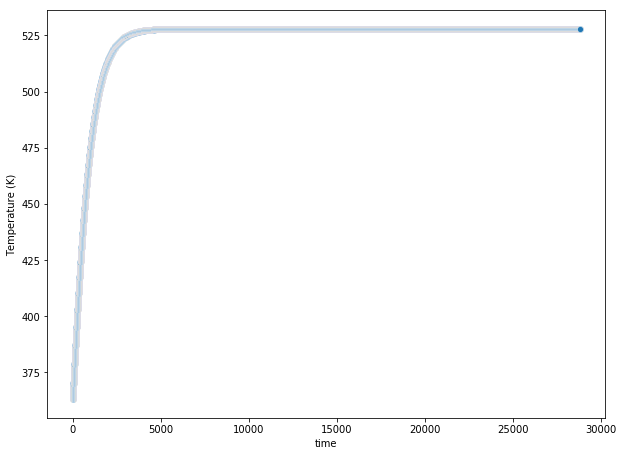

In [57]:
# visualizing temperature ramp
fig,ax = plt.subplots(figsize=(10,7.5))
sns.scatterplot(t,T,alpha=0.25)
plt.ylabel("Temperature (K)")
plt.xlabel("time")
plt.show()

In [3]:
# diffusion coefficients ():
D={'P_1':,
    'TNH2':,
    'TCOOH':,
    'TAA':,
    'TCHA':,
    'BACA':,
    'CD':,
    'CL':,
    'W':,
    'AA':,
    'CHA':}

SyntaxError: invalid syntax (<ipython-input-3-33874d72ee69>, line 2)

#### Initializing vectors

In [58]:
# initialize forward rxn constant vector (kg/mol-s)
k1=[0]*N
k2=[0]*N
k3=[0]*N
k4=[0]*N
k5=[0]*N

# initialize reverse rxn constant vector (kg/mol-s)
k1_prime=[0]*N
k2_prime=[0]*N
k3_prime=[0]*N
k4_prime=[0]*N
k5_prime=[0]*N

In [59]:
# initialize number-average degree of polymerizaton vector
x_n=[0]*N
# initialize number-average molecular weight vector
m_n=[0]*N

# track polymer, by-product, and water mass
polymer_mass=[0]*N
byproduct_mass=[0]*N
water_mass=[0]*N

In [60]:
# phase equilibrium vectors

# binary interaction parameters
tau_W_CL=[0]*N
tau_CL_W=[0]*N

# energy interaction parameters
G_W_CL = [0]*N
G_CL_W = [0]*N

# vapor pressure 
P_sat_W = [0]*N

# liquid molar volume
LMV_W = [0]*N

# activity coefficient
ACT_W = [0]*N

In [61]:
# initialize species vectors (liquid phase)
W=[0]*N
CL=[0]*N
CD=[0]*N
AA=[0]*N
CHA=[0]*N
P_1=[0]*N
P_2=[0]*N
P_3=[0]*N
BACA=[0]*N
TNH2=[0]*N
TCOOH=[0]*N
TAA=[0]*N
TCHA=[0]*N

# initialize species vectors (vapor phase)
W_v=[0]*N
CL_v=[0]*N
CD_v=[0]*N
AA_v=[0]*N
CHA_v=[0]*N
P_1_v=[0]*N
P_2_v=[0]*N
P_3_v=[0]*N
BACA_v=[0]*N
TNH2_v=[0]*N
TCOOH_v=[0]*N
TAA_v=[0]*N
TCHA_v=[0]*N


#### Defining equations

In [62]:
# catch div by zero error
def frac(num,den1,den2,den3):
    if (den1+den2+den3) == 0:
        return 0
    else:
        return num/(den1+den2+den3)
    
# rxn rate generator
def R(eqn,index):
    if eqn==1:
        return (k1[index]*CL[index]*W[index])-(k1_prime[index]*P_1[index])
    elif eqn==2:
        return (k2[index]*((P_1[index])**2))-(k2_prime[index]*W[index]*TNH2[index]*frac(TCOOH[index],TCOOH[index],BACA[index],TCHA[index])) 
    elif eqn==3:
        return (k2[index]*P_1[index]*TCOOH[index])-(k2_prime[index]*W[index]*TCOOH[index]*frac(BACA[index],BACA[index],TNH2[index],TAA[index]))
    elif eqn==4:
        return (k2[index]*TNH2[index]*P_1[index])-(k2_prime[index]*W[index]*TNH2[index]*frac(BACA[index],BACA[index],TCOOH[index],TCHA[index]))
    elif eqn==5:
        return (k2[index]*TNH2[index]*TCOOH[index])-(k2_prime[index]*W[index]*BACA[index]*frac(BACA[index],BACA[index],TNH2[index],TAA[index]))
    elif eqn==6:
        return (k3[index]*P_1[index]*CL[index])-(k3_prime[index]*TNH2[index]*frac(TCOOH[index],TCOOH[index],BACA[index],TCHA[index]))
    elif eqn==7:
        return (k3[index]*TNH2[index]*CL[index])-(k3_prime[index]*TNH2[index]*frac(BACA[index],BACA[index],TCOOH[index],TCHA[index]))
    elif eqn==8:
        return (k4[index]*CD[index]*W[index])-(k4_prime[index]*TNH2[index]*frac(TCOOH[index],TCOOH[index],BACA[index],TCHA[index]))
    elif eqn==9:
        return (k5[index]*P_1[index]*CD[index])-(k5_prime[index]*TNH2[index]*frac(BACA[index],BACA[index],TCOOH[index],TCHA[index])*frac(TCOOH[index],TCOOH[index],BACA[index],TCHA[index]))
    elif eqn==10:
        return (k5[index]*TNH2[index]*CD[index])-(k5_prime[index]*TNH2[index]*frac(BACA[index],BACA[index],TCOOH[index],TCHA[index])*frac(BACA[index],BACA[index],TCOOH[index],TCHA[index]))
    elif eqn==11:
        return (k2[index]*AA[index]*P_1[index])-(k2_prime[index]*W[index]*TAA[index]*frac(TCOOH[index],BACA[index],TCOOH[index],0))
    elif eqn==12:
        return (k2[index]*AA[index]*TNH2[index])-(k2_prime[index]*W[index]*TAA[index]*frac(BACA[index],BACA[index],TCOOH[index],0))
    elif eqn==13:
        return (k3[index]*CHA[index]*CL[index])-(k3_prime[index]*TCHA[index]*frac(TNH2[index],TNH2[index],BACA[index],0))
    elif eqn==14:
        return (k2[index]*CHA[index]*P_1[index])-(k2_prime[index]*W[index]*TCHA[index]*frac(TNH2[index],TNH2[index],BACA[index],0))
    elif eqn==15:
        return (k2[index]*CHA[index]*TCOOH[index])-(k2_prime[index]*W[index]*TCHA[index]*frac(BACA[index],TNH2[index],BACA[index],0))
    

In [63]:
# # rxn rate generator
# def R(eqn,index):
#     if eqn==1:
#         return (k1[index]*CL[index]*W[index])-(k1_prime[index]*P_1[index])
#     elif eqn==2:
#         return (k2[index]*((P_1[index])**2))-(k2_prime[index]*W[index]*TNH2[index]*(TCOOH[index]/(TCOOH[index]+BACA[index]+TCHA[index]))) 
#     elif eqn==3:
#         return (k2[index]*P_1[index]*TCOOH[index])-(k2_prime[index]*W[index]*TCOOH[index]*(BACA[index]/(BACA[index]+TNH2[index]+TAA[index])))
#     elif eqn==4:
#         return (k2[index]*TNH2[index]*P_1[index])-(k2_prime[index]*W[index]*TNH2[index]*(BACA[index]/(BACA[index]+TCOOH[index]+TCHA[index])))
#     elif eqn==5:
#         return (k2[index]*TNH2[index]*TCOOH[index])-(k2_prime[index]*W[index]*BACA[index]*(BACA[index]/(BACA[index]+TNH2[index]+TAA[index])))
#     elif eqn==6:
#         return (k3[index]*P_1[index]*CL[index])-(k3_prime[index]*TNH2[index]*(TCOOH[index]/(TCOOH[index]+BACA[index]+TCHA[index])))
#     elif eqn==7:
#         return (k3[index]*TNH2[index]*CL[index])-(k3_prime[index]*TNH2[index]*(BACA[index]/(BACA[index]+TCOOH[index]+TCHA[index])))
#     elif eqn==8:
#         return (k4[index]*CD[index]*W[index])-(k4_prime[index]*TNH2[index]*(TCOOH[index]/(TCOOH[index]+BACA[index]+TCHA[index])))
#     elif eqn==9:
#         return (k5[index]*P_1[index]*CD[index])-(k5_prime[index]*TNH2[index]*(BACA[index]/(BACA[index]+TCOOH[index]+TCHA[index]))*(TCOOH[index]/(TCOOH[index]+BACA[index]+TCHA[index])))
#     elif eqn==10:
#         return (k5[index]*TNH2[index]*CD[index])-(k5_prime[index]*TNH2[index]*(BACA[index]/(BACA[index]+TCOOH[index]+TCHA[index]))*(BACA[index]/(BACA[index]+TCOOH[index]+TCHA[index])))
#     elif eqn==11:
#         return (k2[index]*AA[index]*P_1[index])-(k2_prime[index]*W[index]*TAA[index]*(TCOOH[index]/(BACA[index]+TCOOH[index])))
#     elif eqn==12:
#         return (k2[index]*AA[index]*TNH2[index])-(k2_prime[index]*W[index]*TAA[index]*(BACA[index]/(BACA[index]+TCOOH[index])))
#     elif eqn==13:
#         return (k3[index]*CHA[index]*CL[index])-(k3_prime[index]*TCHA[index]*(TNH2[index]/(TNH2[index]+BACA[index])))
#     elif eqn==14:
#         return (k2[index]*CHA[index]*P_1[index])-(k2_prime[index]*W[index]*TCHA[index]*(TNH2[index]/(TNH2[index]+BACA[index])))
#     elif eqn==15:
#         return (k2[index]*CHA[index]*TCOOH[index])-(k2_prime[index]*W[index]*TCHA[index]*(BACA[index]/(TNH2[index]+BACA[index])))
    

In [64]:
# forward rate constant generator
def nextk(const,index):
    return A_0[const]*exp(-E_0[const]/(R_const*T[index])) + A_c[const]*exp(-E_c[const]/(R_const*T[index]))*(TCOOH[index]+P_1[index])

# backward rate constant generator
def nextk_prime(const,index):
    if const == 1:
        return k1[index]/exp((delS[const]-(delH[const]/T[index]))/R_const)
    if const == 2:
        return k2[index]/exp((delS[const]-(delH[const]/T[index]))/R_const)
    if const == 3:
        return k3[index]/exp((delS[const]-(delH[const]/T[index]))/R_const)
    if const == 4:
        return k4[index]/exp((delS[const]-(delH[const]/T[index]))/R_const)
    if const == 5:
        return k5[index]/exp((delS[const]-(delH[const]/T[index]))/R_const)
    
# number-average degree of polymerization generator
def next_xn(index):
    return (BACA[index]+TCOOH[index]+TNH2[index])/(TNH2[index]+TAA[index])

# number-average molecular weight (kg/mol)
def next_mn(index):
    return ((BACA[index]*MW['BACA'])+(TCOOH[index]*MW['TCOOH'])+(TNH2[index]*MW['TNH2'])+(TAA[index]*MW['TAA'])+(TCHA[index]*MW['TCHA'])+(P_1[index]*MW['P_1']))/(P_1[index]+TNH2[index]+TAA[index])

In [65]:
# define phase equilibrium 

def nextTau_W_CL(index):
    return a['W_CL']+(b['W_CL']/T[index])+(c['W_CL']*log(T[index]))

def nextTau_CL_W(index):
    return a['CL_W']+(b['CL_W']/T[index])+(c['CL_W']*log(T[index]))
    
def nextG_W_CL(index):
    return exp(-alpha*tau_W_CL[index])*tau_W_CL[index]

def nextG_CL_W(index):
    return exp(-alpha*tau_CL_W[index])*tau_CL_W[index]
    
def nextACT_W(index):       # returns NRTL activity coefficient
    X_CL=CL[index]*MW['CL'] # mass fraction caprolactam
    X_W=W[index]*MW['W']    # mass fraction water
    term1= tau_W_CL[index]*(G_CL_W[index]/(X_W+(G_CL_W[index]*X_CL)**2))
    term2= (tau_W_CL[index]*G_W_CL[index])/((X_CL+(X_W*G_W_CL[index]))**2)
    return exp((X_CL**2)*(term1+term2)) 

def nextPsat_W(index):
    return exp(AC['A_W'] + (AC['B_W']/T[index]) + AC['C_W']*log(T[index]) + AC['D_W']*(T[index]**AC['E_W'])) # Pa

def nextLMV_W(index):
    return ((LMVC['B_W'])**(1+((1-T[index])/LMVC['C_W'])*LMVC['D_W']))/LMVC['A_W']

def nextVapor_W(index):     # returns vapor mass fraction water
    X_W=W[index]*MW['W']    # mass fraction water
    return (X_W*ACT_W[index]*P_sat_W[index]*exp(LMV_W[index]*(P[index]-P_sat_W[index])/(R_const*T[index])))/P[index]

In [66]:
# define difference equations

def nextW(dt,index): 
    return W[index]+(R(2,index)+R(3,index)+R(4,index)+R(5,index)+R(11,index)+R(12,index)+R(14,index)+R(15,index)-R(1,index)-R(8,index))*dt

def nextCL(dt,index):
    return CL[index]+(-R(1,index)-R(6,index)-R(7,index)-R(13,index))*dt

def nextCD(dt,index):
    return CD[index]-(R(8,index)+R(9,index)+R(10,index))*dt

def nextAA(dt,index):
    return AA[index]+(-R(11,index)-R(12,index))*dt

def nextCHA(dt,index):
    return CHA[index]+(-R(13,index)-R(14,index)-R(15,index))*dt
            
def nextP_1(dt,index):
    return P_1[index]+((R(1,index))-(2*R(2,index))-R(3,index)-R(4,index)-R(6,index)-R(9,index)-R(11,index)-R(14,index))*dt

def nextP_2(index):
    return TCOOH[index]*(TNH2[index]/(BACA[index]+TNH2[index]))
    
def nextP_3(index):
    return TCOOH[index]*(BACA[index]/(BACA[index]+TNH2[index]))*(TNH2[index]/(BACA[index]+TNH2[index]))
            
def nextBACA(dt,index):
    return BACA[index]+(R(3,index)+R(4,index)+(2*R(5,index))+R(7,index)+R(9,index)+(2*R(10,index))+R(12,index)+R(15,index))*dt
    
def nextTNH2(dt,index):
    return TNH2[index]+(R(2,index)+R(6,index)+R(8,index)+R(9,index)+R(13,index)+R(14,index)-R(5,index)-R(12,index))*dt
    
def nextTCOOH(dt,index):
    return TCOOH[index]+(R(2,index)+R(6,index)+R(8,index)+R(9,index)+R(11,index)-R(5,index)-R(15,index))*dt
    
def nextTAA(dt,index):
    return TAA[index]+(R(11,index)+R(12,index))*dt
    
def nextTCHA(dt,index):
    return TCHA[index]+(R(13,index)+R(14,index)+R(15,index))*dt

#### Initial conditions

In [67]:
# initial mass charge (kg)
W_mass=3
CL_mass=(W_mass)*240
AA_mass=(CL_mass)*0.004/10000
CHA_mass=(CL_mass)*0.004*(5/3)/1000

In [68]:
total_mass = W_mass+CL_mass+AA_mass+CHA_mass

In [69]:
# initial concentration conditions (mol of species/kg of total mixture)
W[0]=W_mass/(MW['W'])/total_mass
CL[0]=CL_mass/(MW['CL'])/total_mass
AA[0]=AA_mass/(MW['AA'])/total_mass
CHA[0]=CHA_mass/(MW['CHA'])/total_mass
# CD[0]=0
# P_1[0]=0
# BACA[0]=0
# TNH2[0]=0
# TCOOH[0]=0
# TAA[0]=0
# TCHA[0]=0

# x_n[0]=0
# m_n[0]=0

k1[0]=A_0[1]*exp(-E_0[1]/(R_const*T[0]))
k2[0]=A_0[2]*exp(-E_0[2]/(R_const*T[0]))
k3[0]=A_0[3]*exp(-E_0[3]/(R_const*T[0]))
k4[0]=A_0[4]*exp(-E_0[4]/(R_const*T[0]))
k5[0]=A_0[5]*exp(-E_0[5]/(R_const*T[0]))

k1_prime[0]=k1[0]/exp((delS[1]-(delH[1]/T[0]))/R_const)
k2_prime[0]=k2[0]/exp((delS[2]-(delH[2]/T[0]))/R_const)
k3_prime[0]=k3[0]/exp((delS[3]-(delH[3]/T[0]))/R_const)
k4_prime[0]=k4[0]/exp((delS[4]-(delH[4]/T[0]))/R_const)
k5_prime[0]=k5[0]/exp((delS[5]-(delH[5]/T[0]))/R_const)

#### Solve difference equations using euler's finite difference method

In [70]:
# solve difference eqns & store each time-step
def sim(t):
    for i in range(len(t)-1):
        tau_W_CL[i+1] = nextTau_W_CL(i)         # binary interaction parameters
        tau_CL_W[i+1] = nextTau_CL_W(i)         # binary interaction parameters
        G_W_CL[i+1] = nextG_W_CL(i)             # energy interaction parameter
        G_CL_W[i+1] = nextG_CL_W(i)             # energy interaction parameter
        P_sat_W[i+1] = nextPsat_W(i)            # vapor pressure
        LMV_W[i+1] = nextLMV_W(i)               # liquid molar volume
        ACT_W[i+1] = nextACT_W(i)               # activity coefficient
        W_v[i+1] = nextVapor_W(i)  
          
        W[i+1]=nextW(dt,i)
        CL[i+1]=nextCL(dt,i)
        CD[i+1]=nextCD(dt,i)
        AA[i+1]=nextAA(dt,i)
        CHA[i+1]=nextCHA(dt,i)
        P_1[i+1]=nextP_1(dt,i)
        BACA[i+1]=nextBACA(dt,i)
        TNH2[i+1]=nextTNH2(dt,i)
        TCOOH[i+1]=nextTCOOH(dt,i)
        TAA[i+1]=nextTAA(dt,i)
        TCHA[i+1]=nextTCHA(dt,i)    

        polymer_mass[i+1] = total_mass*((P_1[i+1]*MW['P_1'])+(BACA[i+1]*MW['BACA'])+(TCHA[i+1]*MW['TCHA'])+(TAA[i+1]*MW['TAA'])+(TNH2[i+1]*MW['TNH2'])+(TCOOH[i+1]*MW['TCOOH'])) 
        byproduct_mass[i+1] = total_mass*(CD[i+1]*MW['CD']) # kg
        water_mass[i+1] = total_mass*(W[i+1]*MW['W']) # kg

        m_n[i+1]=next_mn(i+1)
        x_n[i+1]=next_xn(i+1)

        k1[i+1]=nextk(1,i+1)
        k2[i+1]=nextk(2,i+1)
        k3[i+1]=nextk(3,i+1)
        k4[i+1]=nextk(4,i+1)
        k5[i+1]=nextk(5,i+1)

        k1_prime[i+1]=nextk_prime(1,i+1)
        k2_prime[i+1]=nextk_prime(2,i+1)
        k3_prime[i+1]=nextk_prime(3,i+1)
        k4_prime[i+1]=nextk_prime(4,i+1)
        k5_prime[i+1]=nextk_prime(5,i+1)

In [71]:
# run simulation
sim(t)

In [72]:
# mass fraction of polymer, water, and caprolactam
X_w=[0]*N
X_p=[0]*N
X_c=[0]*N
for i in range(len(t)):
    X_p[i] = (P_1[i]*MW['P_1'])+(BACA[i]*MW['BACA']+TCHA[i]*MW['TCHA'])+(TAA[i]*MW['TAA']+(TNH2[i]*MW['TNH2'])+(TCOOH[i]*MW['TCOOH'])) # kg of polymer / total kg
    X_w[i] = (W[i]*MW['W'])
    X_c[i] = (CL[i]*MW['CL'])
    

In [77]:
df = pd.DataFrame({'t':t,
                  'W':W,
                  'W_v':W_v,
                  'CL':CL,
                  'CD':CD,
                  'AA':AA,
                  'CHA':CHA,
                  'P_1':P_1,
                  'BACA':BACA,
                  'TNH2':TNH2,
                  'TCOOH':TCOOH,
                  'TAA':TAA,
                  'TCHA':TCHA,
                  'k1':k1,
                  'k2':k2,
                  'k3':k3,
                  'k4':k4,
                  'k5':k5,
                  'k1_prime':k1_prime,
                  'k2_prime':k2_prime,
                  'k3_prime':k3_prime,
                  'k4_prime':k4_prime,
                  'k5_prime':k5_prime,
                  'X_p':X_p,
                  'X_w':X_w,
                  'X_c':X_c,
                  'x_n':x_n,
                  'm_n':m_n,
                  'polymer_mass':polymer_mass,
                  'byproduct_mass':byproduct_mass,
                  'water_mass':water_mass})


In [74]:
# desired amount of end product (kg)
pl = 230 # kg (lower bound)
pu = 680 # kg (upper bound)

# time of extraction (hrs)
extract_time = 8
e = 10*3600*extract_time # convert units to dt units (dt==0.1 sec)

# fraction of reactor to be filled at max capacity
r = 0.7

# reactor size in liters (assuming 1 kg/l density)
print("lower bound: ",round((pl/(X_p[e-1]))/r,0),"L \n             ", round(((pl/(X_p[e-1]))/r)*0.264172,0),'gal','\n')
print("upper bound: ",round((pu/(X_p[e-1]))/r,0),"L \n             ", round(((pu/(X_p[e-1]))/r)*0.264172,0),'gal')

lower bound:  413.0 L 
              109.0 gal 

upper bound:  1220.0 L 
              322.0 gal


## Plots

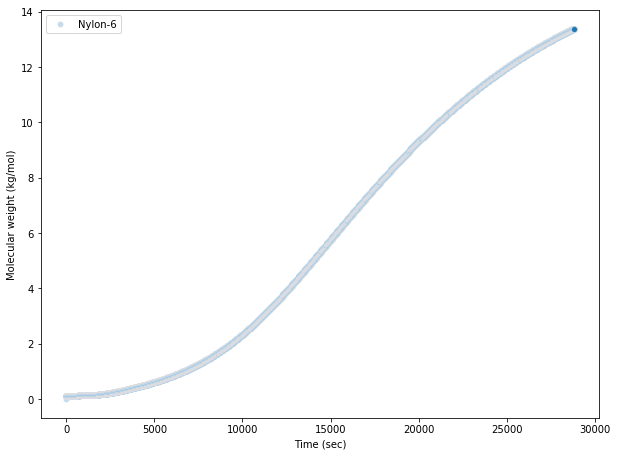

In [75]:
# plot number-average molecular weight over time
fig,ax = plt.subplots(figsize=(10,7.5))
sns.scatterplot(x="t", y="m_n", data=df, ax=ax,label="Nylon-6",alpha=0.25)
plt.ylabel("Molecular weight (kg/mol)")
plt.xlabel("Time (sec)")
#plt.xlim(0,21600)
plt.legend()
plt.show()

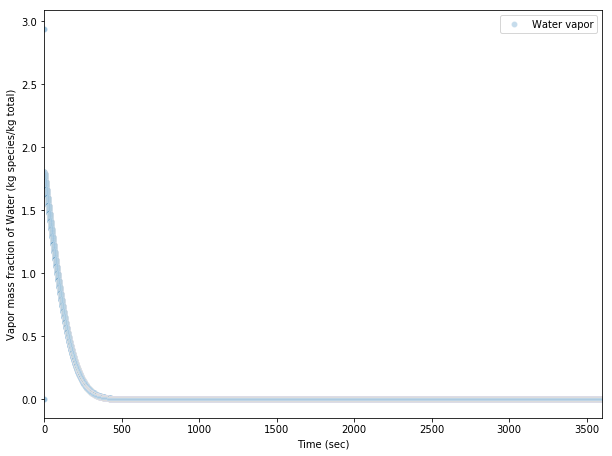

In [81]:
# plot number-average molecular weight over time
fig,ax = plt.subplots(figsize=(10,7.5))
sns.scatterplot(x="t", y="W_v", data=df, ax=ax,label="Water vapor",alpha=0.25)
plt.ylabel("Vapor mass fraction of Water (kg species/kg total)")
plt.xlabel("Time (sec)")
plt.xlim(0,3600)
plt.legend()
plt.show()

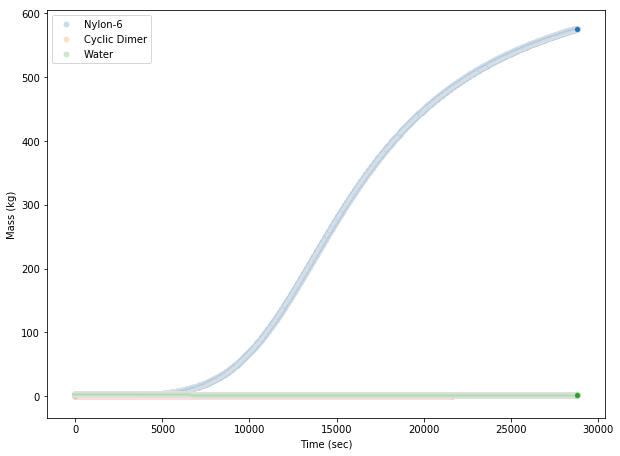

In [76]:
# plot product mass over time
fig,ax1 = plt.subplots(figsize=(10,7.5))
sns.scatterplot(x="t", y="polymer_mass", data=df, ax=ax1,label="Nylon-6",alpha=0.25)
sns.scatterplot(x="t", y="byproduct_mass", data=df, ax=ax1,label="Cyclic Dimer",alpha=0.25)
sns.scatterplot(x="t", y="water_mass", data=df, ax=ax1,label="Water",alpha=0.25)
plt.ylabel("Mass (kg)")
plt.xlabel("Time (sec)")
#plt.xlim(0,21600)
ax.figure.legend()
plt.show()

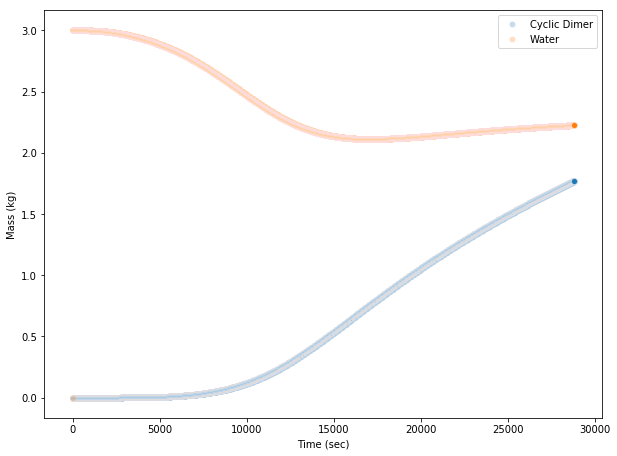

In [42]:
# zoom in to water and by-product mass over time
fig,ax1 = plt.subplots(figsize=(10,7.5))
sns.scatterplot(x="t", y="byproduct_mass", data=df, ax=ax1,label="Cyclic Dimer",alpha=0.25)
sns.scatterplot(x="t", y="water_mass", data=df, ax=ax1,label="Water",alpha=0.25)
plt.ylabel("Mass (kg)")
plt.xlabel("Time (sec)")
#plt.xlim(0,21600)
ax.figure.legend()
plt.show()

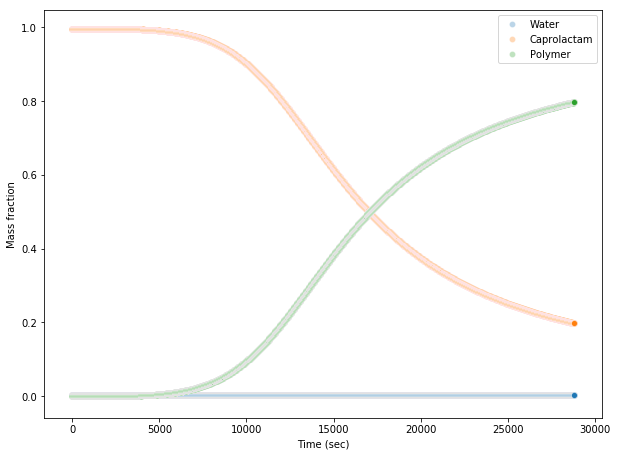

In [43]:
# plot polymer mass fraction as a function of time for each significant species
fig,ax = plt.subplots(figsize=(10,7.5))
sns.scatterplot(x="t", y="X_w", data=df,ax=ax,label="Water",alpha=0.3)
sns.scatterplot(x="t", y="X_c", data=df,ax=ax,label="Caprolactam",alpha=0.3)
sns.scatterplot(x="t", y="X_p", data=df,ax=ax,label="Polymer",alpha=0.3)
plt.ylabel("Mass fraction")
plt.xlabel("Time (sec)")
#plt.xlim(0,21600)
plt.legend()
plt.show()

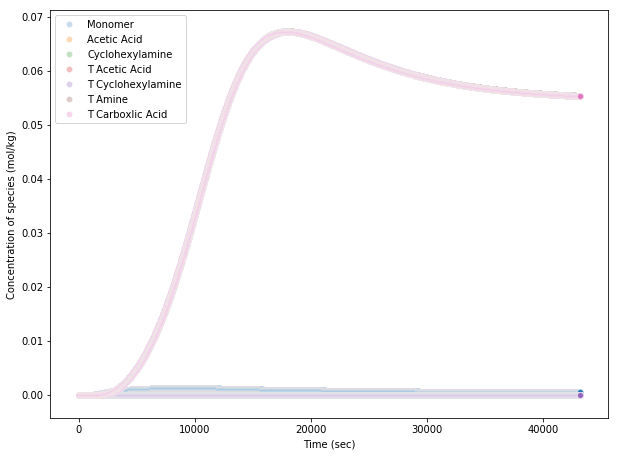

In [119]:
# plot concentration as a function of time for each significant species
fig,ax = plt.subplots(figsize=(10,7.5))
sns.scatterplot(x="t", y="P_1", data=df, ax=ax,label="Monomer",alpha=0.25)
#sns.scatterplot(x="t", y="W", data=df,ax=ax,label="Water",alpha=0.3)
#sns.scatterplot(x="t", y="CL", data=df,ax=ax,label="Caprolactam",alpha=0.3)
#sns.scatterplot(x="t", y="BACA", data=df,ax=ax,label="Bound Nylon-6",alpha=0.3)
sns.scatterplot(x="t", y="AA", data=df,ax=ax,label="Acetic Acid",alpha=0.3)
sns.scatterplot(x="t", y="CHA", data=df,ax=ax,label="Cyclohexylamine",alpha=0.3)
sns.scatterplot(x="t", y="TAA", data=df,ax=ax,label="T Acetic Acid",alpha=0.3)
sns.scatterplot(x="t", y="TCHA", data=df,ax=ax,label="T Cyclohexylamine",alpha=0.3)
#sns.scatterplot(x="t", y="CD", data=df,ax=ax,label="Cyclic Dimer",alpha=0.3)
sns.scatterplot(x="t", y="TNH2", data=df,ax=ax,label="T Amine",alpha=0.3)
sns.scatterplot(x="t", y="TCOOH", data=df,ax=ax,label="T Carboxlic Acid",alpha=0.3)
plt.ylabel("Concentration of species (mol/kg)")
plt.xlabel("Time (sec)")
#plt.xlim(0,21600)
plt.legend()
plt.show()

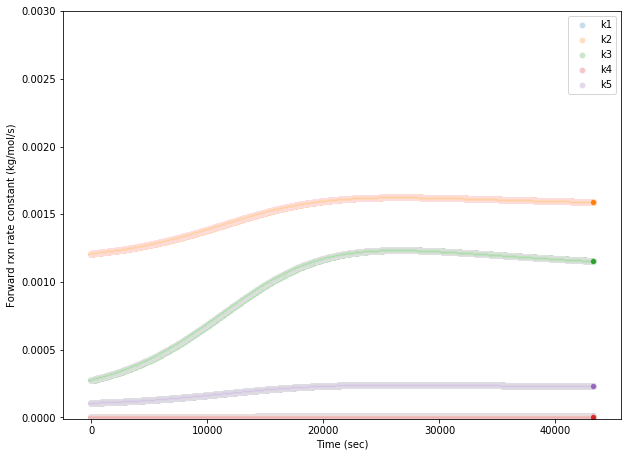

In [26]:
# plot forward rxn rate constants
fig,ax = plt.subplots(figsize=(10,7.5))
sns.scatterplot(x="t", y="k1", data=df, ax=ax,label="k1",alpha=0.25)
sns.scatterplot(x="t", y="k2", data=df,ax=ax,label="k2",alpha=0.25)
sns.scatterplot(x="t", y="k3", data=df,ax=ax,label="k3",alpha=0.25)
sns.scatterplot(x="t", y="k4", data=df,ax=ax,label="k4",alpha=0.25)
sns.scatterplot(x="t", y="k5", data=df,ax=ax,label="k5",alpha=0.25)
plt.ylabel("Forward rxn rate constant (kg/mol/s)")
plt.xlabel("Time (sec)")
#plt.xlim(0,21600)
plt.ylim(-0.00001,0.003)
plt.legend()
plt.show()

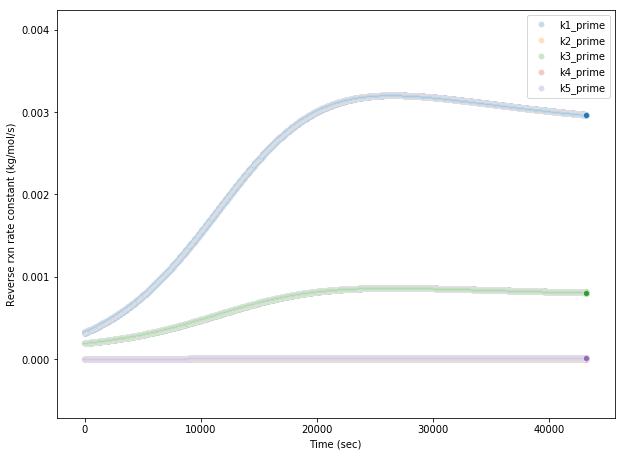

In [23]:
# plot reverse rxn rate constants 
fig, ax = plt.subplots(figsize=(10,7.5))
sns.scatterplot(x="t", y="k1_prime", data=df, ax=ax,label="k1_prime",alpha=0.25)
sns.scatterplot(x="t", y="k2_prime", data=df,ax=ax,label="k2_prime",alpha=0.25)
sns.scatterplot(x="t", y="k3_prime", data=df,ax=ax,label="k3_prime",alpha=0.25)
sns.scatterplot(x="t", y="k4_prime", data=df,ax=ax,label="k4_prime",alpha=0.25)
sns.scatterplot(x="t", y="k5_prime", data=df,ax=ax,label="k5_prime",alpha=0.25)
plt.ylabel("Reverse rxn rate constant (kg/mol/s)")
plt.xlabel("Time (sec)")
#plt.xlim(0,21600)
plt.legend()
plt.show()